## A Bear Image classifer for 3 classes, including teddys, black, and grizzly

- Download your own images from Google images. Please refer to [download_images_from_google.ipynb](download_images_from_google.ipynb) for details

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path=Path('data/bears')
torch.cuda.set_device(1)

### Create ImageDataBunch and take a quick look at the data
- There is no separate validation set, so set aside 20% as validation data set.


['black', 'grizzly', 'teddys']
training size: 409 validate size: 118


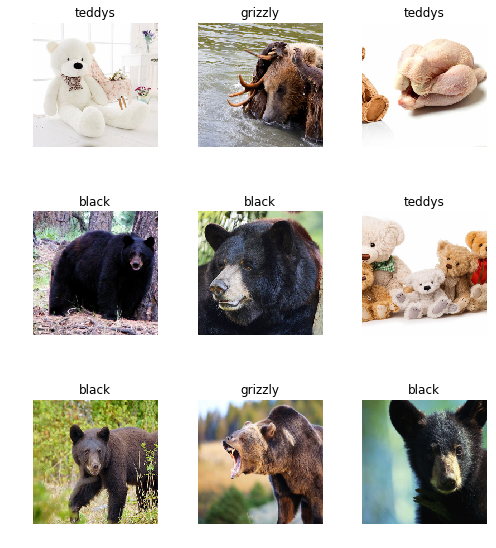

In [4]:
np.random.seed(42)
bs=64
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=bs).normalize(imagenet_stats)
print(data.classes)
print('training size: %s validate size: %s' %(len(data.train_ds), len(data.valid_ds)))
data.show_batch(rows=3, figsize=(7,8))

### Train Model
1. Usually you should use lr_finder first to find the learning rate. (default is 3e-3)
2. Train it first without unfreeze.
3. Unfreeze it and give differential learning rates and train again.
4. Do some data clean up and re-train again.

In [5]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

Total time: 00:50
epoch  train_loss  valid_loss  error_rate
1      0.815525    0.106700    0.025424    (00:13)
2      0.455225    0.067690    0.025424    (00:11)
3      0.317007    0.073743    0.025424    (00:12)
4      0.257317    0.075433    0.025424    (00:13)



In [6]:
learn.save('stage-1')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


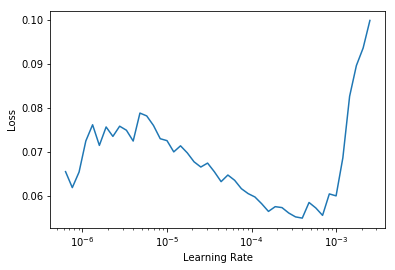

In [7]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(4,max_lr=slice(3e-5,3e-4))

Total time: 00:38
epoch  train_loss  valid_loss  error_rate
1      0.047938    0.077419    0.025424    (00:09)
2      0.057580    0.081102    0.033898    (00:09)
3      0.053351    0.086951    0.033898    (00:09)
4      0.044148    0.083930    0.033898    (00:09)



In [45]:
learn.save('stage-2')

### Interpretation

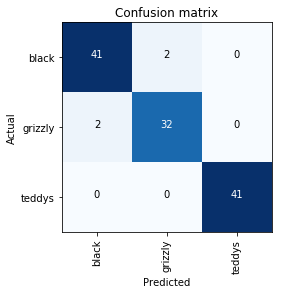

In [46]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Data Clean up and then do the re-train

In [47]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]
fd = FileDeleter(file_paths=top_loss_paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

### Inference

In [51]:
classes = ['black', 'grizzly', 'teddys']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('stage-2')

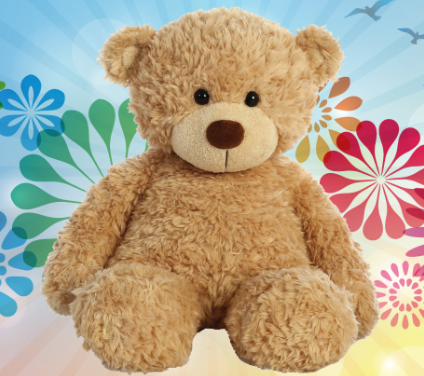

In [52]:
#img = open_image(path/'black'/'00000021.jpg')
img = open_image(path/'teddys'/'00000021.jpg')
#img = open_image(path/'grizzly'/'00000021.jpg')
img

In [53]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,pred_idx,outputs)

teddys tensor(2) tensor([3.5835e-03, 2.0796e-02, 1.0229e+03])
